In [1]:
import scipy.io as spio
import csv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set(style='darkgrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 10]})
sns.set_context("talk")

def display_image_in_actual_size(im_path):
    # function from stackoverflow https://bit.ly/2WHnH6i
    
    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [2]:
# Load mat file to array
mat = spio.loadmat(os.path.join('..', 'dataframe', 'mat_files', 'cars_train_annos.mat'), squeeze_me=True)
row_mat = mat['annotations']

mat_class = spio.loadmat(os.path.join('..', 'dataframe', 'mat_files', 'cars_meta.mat'), squeeze_me=True)
row_mat_class = mat_class['class_names']

In [3]:
data_array = []
class_dict = {}

# Map class id and name
for i, row in enumerate(row_mat_class):
    class_dict[i+1] = row
    
# Clean up data and store the width, height and class of each image
for row in row_mat:
    x1, y1, x2, y2, car_id, file_path = row
    data_array.append([file_path, abs(x2-x1), abs(y2-y1), int(car_id)])

# Convert to pandas dataframe
cars_df = pd.DataFrame(data_array, columns=['filepath', 'width', 'height', 'class'])

In [4]:
cars_df = cars_df.sort_values(by=['class'])

In [5]:
cars_df.head()

,filepath,width,height,class
6173,06174.jpg,299,178,1
5920,05921.jpg,796,470,1
3392,03393.jpg,1720,776,1
4543,04544.jpg,310,172,1
945,00946.jpg,393,178,1


In [6]:
cars_df.describe(exclude='O').transpose()

,count,mean,std,min,25%,50%,75%,max
width,8144.0,573.301817,375.675050,73.0,338.0,504.0,659.0,4156.0
height,8144.0,307.770383,213.463238,23.0,173.0,260.0,370.0,2648.0
class,8144.0,98.979371,56.503148,1.0,50.0,99.0,148.0,196.0


***

## Analysis of the number of images per class

### Zoom in at the lower count of images per class

(176, 196)

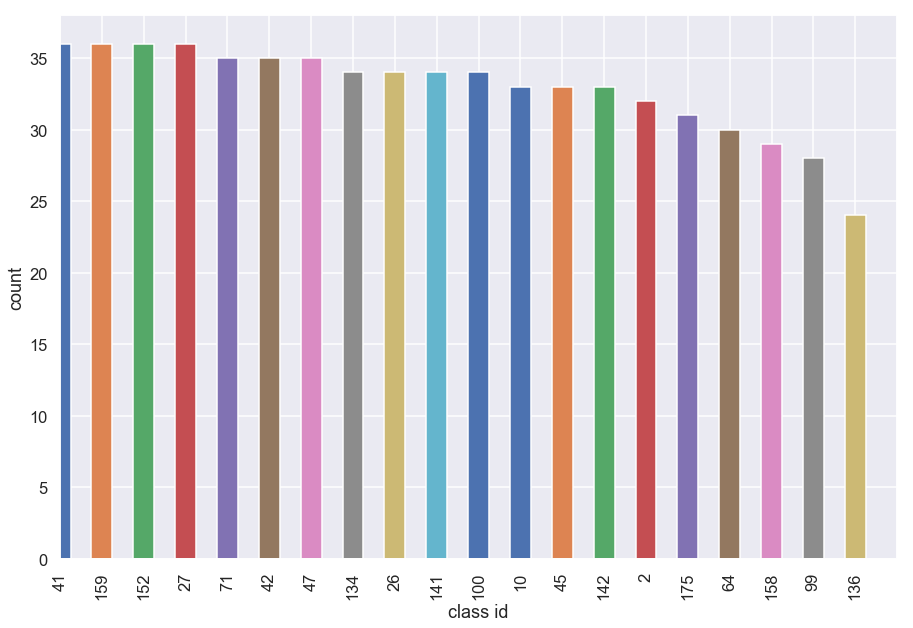

In [7]:
cars_df['class'].value_counts().plot('bar', figsize=(15,10))
plt.xlabel('class id')
plt.ylabel('count')
plt.ylim(0, 38)
plt.xlim(176,196)

### Zoom in at the higher count of images per class

(-1, 18)

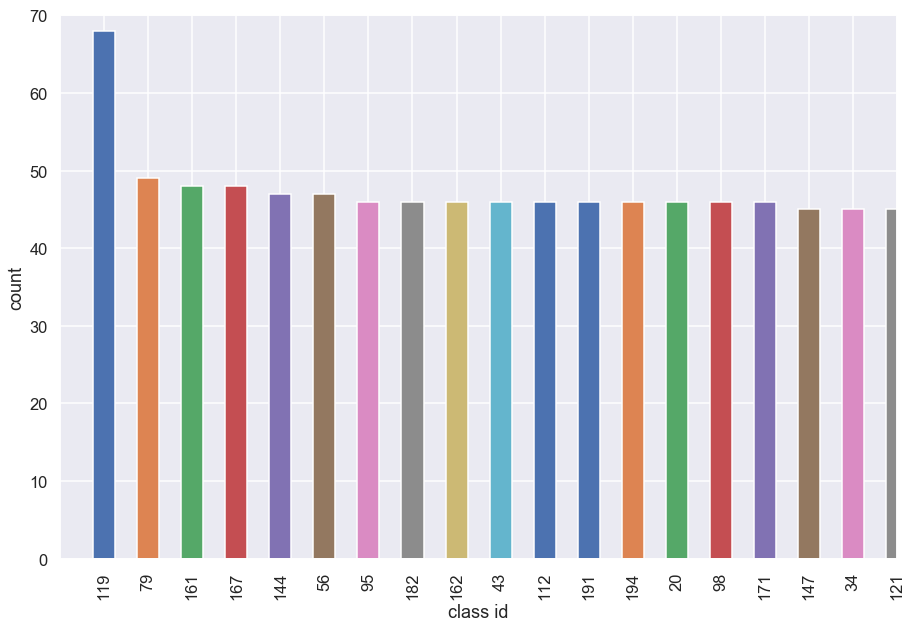

In [8]:
# Zoom in at the higher count of images per class
cars_df['class'].value_counts().plot('bar', figsize=(15,10))
plt.xlabel('class id')
plt.ylabel('count')
plt.ylim(0, 70)
plt.xlim(-1,18)

In [9]:
print("Lowest images count :", class_dict[136])
print("Highest images count :", class_dict[119])

Lowest images count : Hyundai Accent Sedan 2012
Highest images count : GMC Savana Van 2012


* __We can see that there are one extreme class at both ends.__
* __The Hyundai Accent Sedan has the lowest sample of only 24 images while GMC Savana Van has very high sample of 68 images, which is about 3 times higher than Hyundai Accent Sedan__

***

## Analysis of the image size

### Distribution of image size in pixels

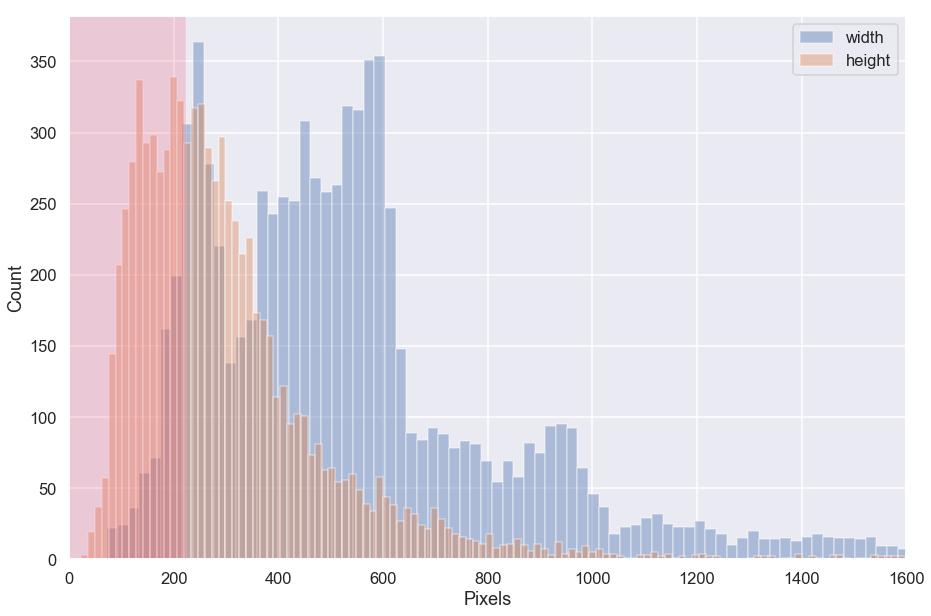

In [10]:
sns.set(style='darkgrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 10]})
sns.set_context("talk")
sns.distplot(
    cars_df['width'], label='width', norm_hist=False, kde=False, bins=200, hist_kws={"alpha": 0.4}
).set(xlabel='Pixels', ylabel='Count');

sns.distplot(
    cars_df['height'], label='height', norm_hist=False, kde=False, bins=200, hist_kws={"alpha": 0.4}
).set(xlabel='Pixels', ylabel='Count');

# Set vertical bar for threshold of image size less than 224
plt.axvspan(0, 224, facecolor='#f44262', alpha=0.2)
plt.xlim(0, 1600)
plt.legend()

### Distribution ratio of width and height

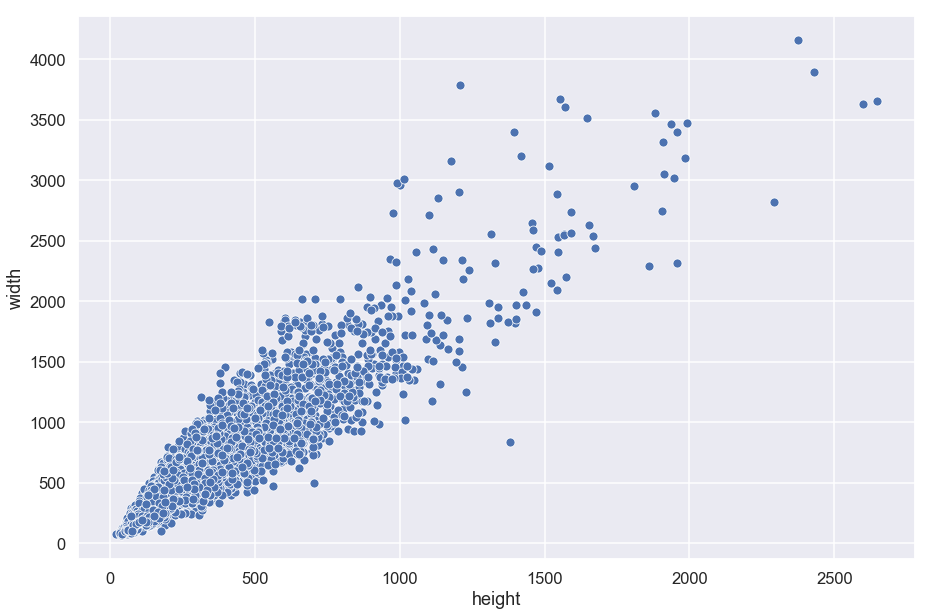

In [11]:
sns.scatterplot(x=cars_df['height'], y=cars_df['width']);

* __The image size distribution looks normal, width size skewed more to the right shows that images are rectangle. Since we are using DenseNet169, which using image size of 224, we only concern for images that has smaller size than 224, because when we resize back to 224x224 during training, the images will be pixelated and it affect the model quality.__
* __The image ratio also looks normal telling us that the bounding box were correctly annotated__

***

## Plotting the images

### Since small size images will affect the accuracy of the image classification, let analyze them

In [12]:
# Let see how many images has width less than 100 pixels and 224 pixels
len_width = len(cars_df[cars_df['width'] < 100])
len_height = len(cars_df[cars_df['height'] < 100])

len_width_224 = len(cars_df[cars_df['width'] < 224])
len_height_224 = len(cars_df[cars_df['height'] < 224])

print("Images with width less than 100px : {}, which is {:.2f}% from train dataset".format(len_width, (len_width/8144)*100))
print("Images with height less than 100px : {}, which is {:.2f}% from train dataset".format(len_height, (len_height/8144)*100))
print('---------------------------------------------------------------------------')
print("Images with width less than 224px : {}, which is {:.2f}% from train dataset".format(len_width_224, (len_width_224/8144)*100))
print("Images with height less than 224px : {}, which is {:.2f}% from train dataset".format(len_height_224, (len_height_224/8144)*100))

Images with width less than 100px : 28, which is 0.34% from train dataset
Images with height less than 100px : 432, which is 5.30% from train dataset
---------------------------------------------------------------------------
Images with width less than 224px : 675, which is 8.29% from train dataset
Images with height less than 224px : 3229, which is 39.65% from train dataset


* __Since the images are rectangle, width size will contribute to how small the images are. So we will focus on width instead of height__
* __Visually, images with width less than 100px are hard to tell make and model, hence why I set the threshold to 100px__

In [13]:
# View image path so we can plot later
print(cars_df.loc[cars_df['width'] < 100])

       filepath  width  height  class
5803  05804.jpg     90      48      1
461   00462.jpg     78      50      1
5753  05754.jpg     92      79      1
521   00522.jpg     88      61      1
5656  05657.jpg     86      51      1
5223  05224.jpg     88      44      1
1608  01609.jpg     94      67     18
2291  02292.jpg     81      46     18
3434  03435.jpg     83      39     18
96    00097.jpg     73      43     57
2046  02047.jpg     93      40     57
6283  06284.jpg     76      23     57
7468  07469.jpg     73      39     57
4589  04590.jpg     98      47     62
1418  01419.jpg     99      60     70
1039  01040.jpg     77      58     88
5341  05342.jpg     92      84     88
7463  07464.jpg     94      57    107
2747  02748.jpg     97      85    119
2427  02428.jpg     87      57    123
1786  01787.jpg     87      42    123
6483  06484.jpg     91      36    123
7346  07347.jpg     80      37    123
4666  04667.jpg     88      50    123
4046  04047.jpg     88      35    123
8086  08087.

Sample of very small images in the dataset


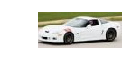

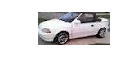

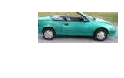

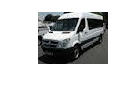

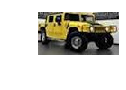

Reference images that has standard size input of DenseNet which is 224


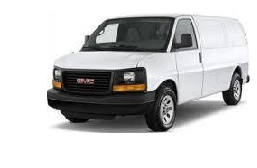

In [14]:
print("Sample of very small images in the dataset")
display_image_in_actual_size('../data/crop_images/train/02047.jpg')
display_image_in_actual_size('../data/crop_images/train/07347.jpg')
display_image_in_actual_size('../data/crop_images/train/04047.jpg')
display_image_in_actual_size('../data/crop_images/train/01040.jpg')
display_image_in_actual_size('../data/crop_images/train/05804.jpg')

print("Reference images that has standard size input of DenseNet which is 224")
display_image_in_actual_size('../data/crop_images/train/06626.jpg')

- __As we can see, the images with less than 100 pixels width are very small. Even as a human, we can hardly identify the make and model of the cars except vehicle that have unique shape such as Hummer, Supercars__
- __This can lead to bad generalization of the prediction of the model__
- __But the small images count is very small compared to the whole dataset, which is less than 0.3%__
- __To further improve accuracy in the future, we can replace these small size images with the standard model size image (usually 224 x 224)__

***

## Augment the images

- __To improve training accuracy, we can augment the images to make it adapt to many more possibilities in real life situation.__
- __There are many type of augmentation we can use, but I will just use rotation, padding and zooming since it was shown to improve accuracy and lower the losses__ (https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)
- __Adding more complicated augmentation such as salt and pepper, constrast and cutout to image classification will reduce accuracy and increase loss.__ (This may differ for other training objective; depends from case to case)

Found 8144 images belonging to 196 classes.


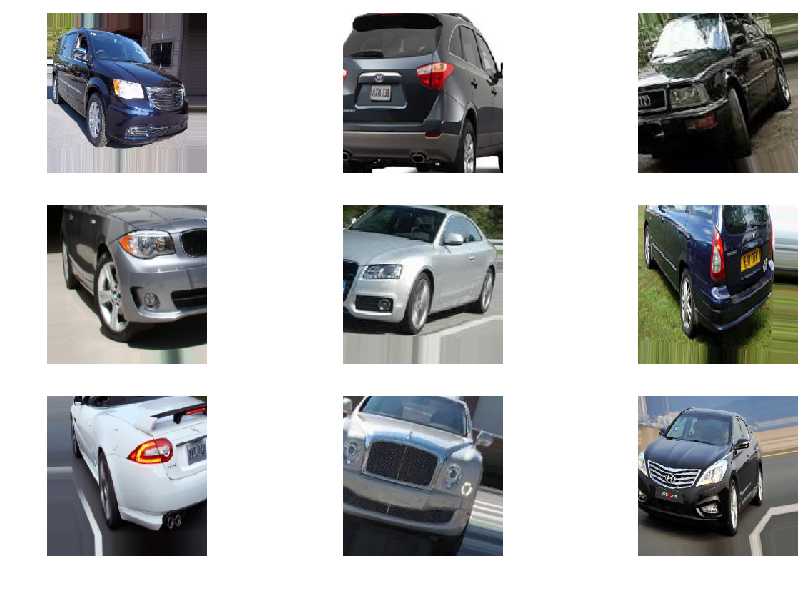

In [15]:
from keras_preprocessing.image import ImageDataGenerator

# Rescale the image to 0-1
def preprocess_input(x):
    x /= 255
    return x

# Use keras ImageDataGenerator function to do augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=17.0,
    width_shift_range=0.18,
    height_shift_range=0.18,
    zoom_range=0.32,
    horizontal_flip=True
)

# Apply the augmentation to the dataset
train_generator = datagen.flow_from_dataframe(
    cars_df,
    directory='../data/crop_images/train',
    x_col="filepath",
    y_col="class",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=9
)

plt.rcParams["axes.grid"] = False

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in train_generator:
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(224, 224, 3)), plt.axis('off')
    # show the plot
    plt.show()
    break